In [1]:
import math
import matplotlib.pyplot as plt
import random
import numpy as np
# calculus
import sympy as sym
# gamma
from scipy.special import gamma, gammaln
from mpmath import mp, gamma
mp.dps = 10  # You can set this to be high enough to handle the precision you need

## Capture probability function

In [2]:
# consider x and y
def P_cap(Px, Py, CR):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = math.sqrt(Py * Pr / Px)
    slope_2 = math.sqrt(Py / (Px * Pr))

    if slope_1 > 1 and slope_2 < 1:
        result = (1 / math.sqrt(Pr * Py / Px) / 2) + (math.sqrt(Py / (Pr * Px)) / 2)
    elif slope_1 > 1 and slope_2 >= 1:
        result = 1 - (1 / math.sqrt(Py / (Pr * Px)) - 1 / math.sqrt(Pr * Py / Px)) / 2
    elif slope_1 <= 1 and slope_2 < 1:
        result = 1 - (math.sqrt(Pr * Py / Px) - math.sqrt(Py / (Pr * Px))) / 2
    return result

# only consider x capture
def P_cap_only_x(Px, Py, CR):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = math.sqrt(Py * Pr / Px)
    slope_2 = math.sqrt(Py / (Px * Pr))

    if slope_1 > 1 and slope_2 < 1:
        result = (1 / math.sqrt(Pr * Py / Px) / 2)
    elif slope_1 > 1 and slope_2 >= 1:
        result = (1 / math.sqrt(Pr * Py / Px) / 2)
    elif slope_1 <= 1 and slope_2 < 1:
        result = 1 - math.sqrt(Pr*Py/Px) / 2
    return result

In [3]:
def gamma_function(z):
    gamma_result = gamma(mp.mpf(str(z)))
    return gamma_result

In [4]:
def getPower(n, step, scheme):
    if scheme == 1:
        power_sum = 0
        for i in range(step):
            power_sum += 2 ** (i if i <= (step - 1) else (step - 1))
        return power_sum / step
    else:
        return 2 ** (n-1 if n-1 <= (step - 1) else (step - 1))

In [436]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    # 第一步: **$M_i$個STA隨機選擇 $R$ 個RA-RU，剛好 $x$ 個STA選到第一個RA-RU (碰撞)**
    first_RU_have_2_STA_count = [0 for _ in range(0,Imax)]
    # 第二步：**在碰撞的x個STAs裡有y個第n次傳送STA** (設定n=2) [n][i]
    collision_STA_have_0_nth_count = [[0 for _ in range(0,Imax)] for _ in range(0,Lmax)]
    collision_STA_have_1_nth_count = [[0 for _ in range(0,Imax)] for _ in range(0,Lmax)]
    collision_STA_have_2_nth_count = [[0 for _ in range(0,Imax)] for _ in range(0,Lmax)]
    # 第三步：**在x個STA碰撞下，裡面有y個第n次傳送STA，第n次傳送STA被捕獲**
    have_1_nth_capture_count = [[0 for _ in range(0,Imax)] for _ in range(0,Lmax)]
    have_2_nth_capture_count = [[0 for _ in range(0,Imax)] for _ in range(0,Lmax)]

    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]

        #/** statistics */  
        for n in range (1, Lmax+1):
            if (M[i] >= 2):
                #/** Calculate capture probability for slot i */
                capture_prob_n_k = 0
                capture_prob_n2 = 0
                Pn = getPower(n=n, step=step, scheme=2)
                capture_prob_n2 += P_cap(Pn, Pn, CR)
                # calculate the capture prob. when n-th with k-th (K!=n)
                for k in range(1, Lmax+1):
                    Pk = getPower(n=k, step=step, scheme=2)
                    if (n != k):
                        if (M[i] > M_i[i][n]):
                            capture_prob_n_k += P_cap_only_x(Pn, Pk, CR) * (M_i[i][k] / (M[i] - M_i[i][n]))
                # 沒有 M_i[i][n] 當然沒機會capture
                if (M_i[i][n] == 0):
                    capture_prob_n_k = 0
                    capture_prob_n2 = 0
                # divided result
                first_RU_have_2_STA_count[i-1] += (1 / Ri[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                collision_STA_have_0_nth_count[n-1][i-1] += ((M[i] - M_i[i][n]) / M[i]) ** 2
                collision_STA_have_1_nth_count[n-1][i-1] += 2 * (M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i])
#                 collision_STA_have_1_nth_count[n-1][i-1] += 2 * (M_i[i][n] / M[i]) * ((M_i[i][n] - 1) / (M[i] - 1))
                collision_STA_have_2_nth_count[n-1][i-1] += ((M_i[i][n] / M[i]) ** 2)
                have_1_nth_capture_count[n-1][i-1] += capture_prob_n_k
                have_2_nth_capture_count[n-1][i-1] += capture_prob_n2
            
#                 print(f'n={n}, capture_prob_n2={capture_prob_n2}')
#                 print(collision_STA_have_0_nth_count[n-1][i-1] + collision_STA_have_1_nth_count[n-1][i-1] + collision_STA_have_2_nth_count[n-1][i-1])
#                 if (((M[i] - M_i[i][n]) / M[i]) ** 2 + (M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) + ((M_i[i][n] / M[i]) ** 2) != 1):
#                     print(f'M[i]: {M[i]}')
#                 print(((M[i] - M_i[i][n]) / M[i]) ** 2 + 2 * (M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) + ((M_i[i][n] / M[i]) ** 2))
                
#                 M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * (M_i[i][n] / M[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += capture_prob_n2 * ((M_i[i][n] / M[i]) ** 2) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += capture_prob_n_k * 2 *  (M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
#                 M_i_s[i][n] = M_i[i][n] * ((1 - 1 / Ri[i]) ** (M[i] - 1)) + capture_prob * (M_i[i][n] / M[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * ((1 - 1 / Ri[i]) ** (M[i]-2))
            if (M[i] < 2):
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])
#                 M_i_s[i][n] = M_i[i][n] * ((1 - 1 / Ri[i]) ** (M[i] - 1))
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]
#             if M_i[i][n] < 0 or M_i_s[i][n] < 0 or M_i_f[i][n] < 0:
#                 print(f'i={i}, n={n}, capture_prob={capture_prob}, M_i[i][n]={M_i[i][n]}, M_i_s[i][n]={M_i_s[i][n]}, M_i_f[i][n]={M_i_f[i][n]}')
        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    first_RU_have_2_STA_count = [x / Lmax for x in first_RU_have_2_STA_count]
    return first_RU_have_2_STA_count, collision_STA_have_0_nth_count, collision_STA_have_1_nth_count, collision_STA_have_2_nth_count, have_1_nth_capture_count, have_2_nth_capture_count

In [437]:
sta_amount = 100
Imax = 0
Lmax = 5
RA_RU = 9
ocw_min = 7
ocw_max = 31
ocw = [0 for _ in range(0, Lmax)]
ocw[0] = ocw_min
for n in range (1, Lmax):
    temp_ocw = ocw[n-1] * 2 + 1
    if temp_ocw <= ocw_max:
        ocw[n] = temp_ocw
    else:
        ocw[n] = ocw[n-1]
# Imax: Reserved slot for transmission (total slots in worst case)
Imax = 0
for n in range(0, Lmax):
    Imax += math.ceil(ocw[n] / RA_RU)
    
i_list = [i+1 for i in range(Imax)]

In [438]:
first_RU_have_2_STA, collision_STA_have_0_nth, collision_STA_have_1_nth, collision_STA_have_2_nth, have_1_nth_capture, have_2_nth_capture = analytical(sta_amount=sta_amount, RA_RU=RA_RU, Lmax=Lmax, TXOP=5.673, ocw_min=ocw_min, ocw_max=ocw_max, CR=1.5, step=4)
# print(f'collision_STA_have_0_nth: {collision_STA_have_0_nth}')
# print(f'collision_STA_have_1_nth: {collision_STA_have_1_nth}')
# print(f'collision_STA_have_2_nth: {collision_STA_have_2_nth}')

# sum_collision_STA = [[sum(element) for element in zip(row0, row1, row2)]
#                      for row0, row1, row2 in zip(collision_STA_have_0_nth, collision_STA_have_1_nth, collision_STA_have_2_nth)]

# print(f'sum_collision_STA n=1: {sum_collision_STA[0]}')
# print(f'sum_collision_STA n=2: {sum_collision_STA[1]}')
# print(f'sum_collision_STA n=3: {sum_collision_STA[2]}')
# print(f'sum_collision_STA n=4: {sum_collision_STA[3]}')
# print(f'sum_collision_STA n=5: {sum_collision_STA[4]}')


In [439]:
# sample = 1000000
first_RU_have_2_STA_simu = [0.00062, 0.020774, 0.032923, 0.151309, 0.087623, 0.075576, 0.110722, 0.15077, 0.207127, 0.270545, 0.229939, 0.100655, 0.019373, 0.001156, 1.2e-05]
collision_STA_have_0_nth_simu = [[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.0, 0.1156812688873101, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.43407925106822715, 0.0295094726242588, 0.13074488657446395, 0.36256170643507346, 0.7816771196748472, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.6870409985701837, 0.4616792272905145, 0.27716806889115464, 0.17333506854937608, 0.25004375215530134, 0.4422171170327001, 0.6797083455719917, 0.9036944993634353, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.9212942149367368, 0.7606237759570457, 0.4894770826346586, 0.2493651322275053, 0.11286346202934515, 0.030779300170888695, 0.002427478651084002, 0.0, 0.0, 0.0, 0.0]]
collision_STA_have_1_nth_simu = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.45023948004446274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.45023948004446274, 0.28344952880555746, 0.4604938725009086, 0.4786614929839875, 0.20502745478844547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.28344952880555746, 0.4349707523836902, 0.4978412833471478, 0.48585014740993976, 0.5005911156171934, 0.4449194209379547, 0.28951235425711963, 0.0938780219854807, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.07709871751197069, 0.22279012110231716, 0.42014385608385096, 0.5005911156171934, 0.4449194209379547, 0.28951235425711963, 0.0938780219854807, 0.0, 0.0, 0.0, 0.0]]
collision_STA_have_2_nth_simu = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.43407925106822715, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.1156812688873101, 0.6870409985701837, 0.4087612409246274, 0.15877680058093904, 0.013295425536707327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0295094726242588, 0.10335002032579527, 0.22499064776169764, 0.34081478404068416, 0.2493651322275053, 0.11286346202934515, 0.030779300170888695, 0.002427478651084002, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0016070675512925559, 0.016586102940637126, 0.09037906128149041, 0.25004375215530134, 0.4422171170327001, 0.6797083455719917, 0.9036944993634353, 1.0, 1.0, 1.0, 1.0]]
have_1_nth_capture_simu = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.300126084363274, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.5766434379506383, 0.29696977531866486, 0.2992577477222288, 0.30010236543848573, 0.30133541661580526, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.5789797554101921, 0.5679144260471833, 0.5393510060231733, 0.46443502574574047, 0.42185393341298993, 0.42438748659502823, 0.4250013854292628, 0.4260468094775765, 0, 0, 0, 0], [0, 0, 0, 0, 0.5224047306176084, 0.48802892023231004, 0.44241198223442174, 0.41660397397884674, 0.41249307056764456, 0.4119186703289364, 0.409076824557417, 0, 0, 0, 0]]
have_2_nth_capture_simu = [[0.8493731563421829, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0.8410138745260255, 0.860928604430801, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.8609209250389351, 0.8990746419904531, 0.9026715369625092, 0.8968040579870832, 0.8747835253369475, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.909501812943923, 0.8980749672217525, 0.8947354693999974, 0.9175109048451292, 0.9506536963828307, 0.9826844164519515, 0.9696200163060186, 0.8729778310365488, 0, 0, 0, 0], [0, 0, 0, 0, 0.8455476753349094, 0.865292764903591, 0.9085743401158605, 0.9473294075259735, 0.9599679968045516, 0.9224342563171433, 0.8555196886680246, 0.8297221348085088, 0.8260088399058607, 0.8191007990757678, 0.8229166666666666]]

In [440]:
# sample = 100000
first_RU_have_2_STA_simu = [0.00054, 0.02024, 0.03177, 0.15117, 0.08695, 0.0755, 0.10942, 0.14913, 0.20574, 0.26774, 0.22757, 0.09848, 0.01901, 0.00122, 1e-05]
collision_STA_have_0_nth_simu = [[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.0, 0.1205037817858243, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.433587734008693, 0.029888826799211787, 0.1310919923917014, 0.3612449975170157, 0.7813540177723579, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.6863327549189729, 0.4620403844458161, 0.27924809394443956, 0.17134632108193476, 0.2508224048149405, 0.44058128407221425, 0.6807181343314276, 0.9046940230119133, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.9198861274515979, 0.7608301930885403, 0.49286806673130557, 0.24918497101299622, 0.1132622229868496, 0.030563895858182866, 0.0023031308032835374, 0.0, 0.0, 0.0, 0.0]]
collision_STA_have_1_nth_simu = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.44590848420548274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.44590848420548274, 0.2837784182818152, 0.4606169775907894, 0.47820816171530395, 0.2049818578011455, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.2837784182818152, 0.43481930290853665, 0.4964215815149125, 0.486170946493008, 0.4999926241720633, 0.4461564929409361, 0.2887179698103895, 0.09300284618480321, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.07852671092244322, 0.2227236876697923, 0.4177103845346501, 0.4999926241720633, 0.4461564929409361, 0.2887179698103895, 0.09300284618480321, 0.0, 0.0, 0.0, 0.0]]
collision_STA_have_2_nth_simu = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.433587734008693, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.1205037817858243, 0.6863327549189729, 0.40829103001750916, 0.1605468407676803, 0.013664124426496607, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.029888826799211787, 0.10314031264564727, 0.2243303245406479, 0.3424827324250572, 0.24918497101299622, 0.1132622229868496, 0.030563895858182866, 0.0023031308032835374, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.00158716162595891, 0.016446119241667397, 0.08942154873404436, 0.2508224048149405, 0.44058128407221425, 0.6807181343314276, 0.9046940230119133, 1.0, 1.0, 1.0, 1.0]]
have_1_nth_capture_simu = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.29795072530508865, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.5754854555222965, 0.2985101697111025, 0.2973992944458118, 0.3002351791331969, 0.3021894962695665, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.5796605777950512, 0.5681219038790232, 0.5398670118865482, 0.4663431884534726, 0.4196465451112291, 0.42479454365796643, 0.42340019374323323, 0.4274021166779626, 0, 0, 0, 0], [0, 0, 0, 0, 0.5242220083413539, 0.48134303888779595, 0.4410251501591328, 0.41706496725084086, 0.41333477936037405, 0.41375576955951904, 0.40790365465825557, 0, 0, 0, 0]]
have_2_nth_capture_simu = [[0.8314606741573034, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0.8447816392016099, 0.837477306811903, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.8383981823345641, 0.8396361844360645, 0.8404652454262179, 0.8374272197962155, 0.8324798829553768, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.8538745387453874, 0.8403761602344895, 0.843153851162185, 0.8365292005953945, 0.8385330333885863, 0.8370437176626953, 0.8490109002826, 0.8610526315789474, 0, 0, 0, 0], [0, 0, 0, 0, 0.8253968253968254, 0.8365896980461812, 0.8381399508160071, 0.8377933305887196, 0.8374110727403629, 0.8338640387183314, 0.831771042688319, 0.8301014568447255, 0.8263348885432866, 0.8243243243243243, 0.7142857142857143]]

In [441]:
# Excluding last three elements from each sub-array
exclude_idx = 3
i_list = i_list[:-exclude_idx]

first_RU_have_2_STA_simu = first_RU_have_2_STA_simu[:-exclude_idx]
collision_STA_have_0_nth_simu = [sub_array[:-exclude_idx] for sub_array in collision_STA_have_0_nth_simu]
collision_STA_have_1_nth_simu = [sub_array[:-exclude_idx] for sub_array in collision_STA_have_1_nth_simu]
collision_STA_have_2_nth_simu = [sub_array[:-exclude_idx] for sub_array in collision_STA_have_2_nth_simu]
have_1_nth_capture_simu = [sub_array[:-exclude_idx] for sub_array in have_1_nth_capture_simu]
have_2_nth_capture_simu = [sub_array[:-exclude_idx] for sub_array in have_2_nth_capture_simu]

first_RU_have_2_STA = first_RU_have_2_STA[:-exclude_idx]
collision_STA_have_0_nth = [sub_array[:-exclude_idx] for sub_array in collision_STA_have_0_nth]
collision_STA_have_1_nth = [sub_array[:-exclude_idx] for sub_array in collision_STA_have_1_nth]
collision_STA_have_2_nth = [sub_array[:-exclude_idx] for sub_array in collision_STA_have_2_nth]
have_1_nth_capture = [sub_array[:-exclude_idx] for sub_array in have_1_nth_capture]
have_2_nth_capture = [sub_array[:-exclude_idx] for sub_array in have_2_nth_capture]

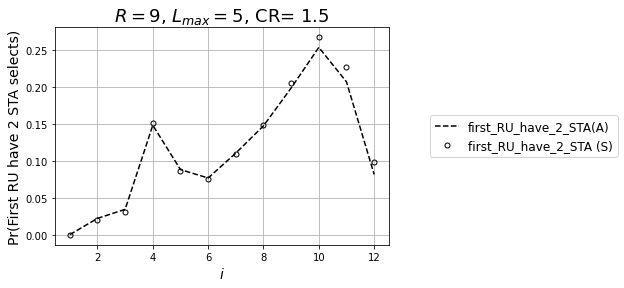

In [442]:
plt.plot(i_list, first_RU_have_2_STA, linestyle = '--', color='black', label='first_RU_have_2_STA(A)')

plt.plot(i_list, first_RU_have_2_STA_simu, label='first_RU_have_2_STA (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)

plt.title('$R = $' + str(RA_RU) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$i$", fontsize = 14)
plt.ylabel("Pr(First RU have 2 STA selects)", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

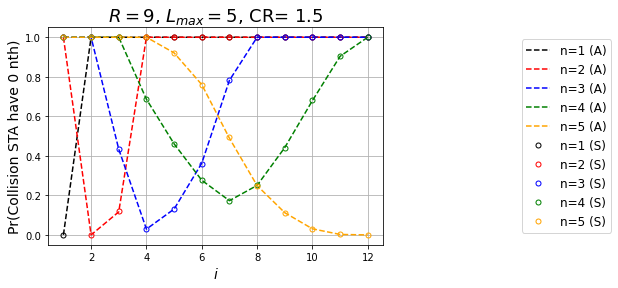

In [443]:
# i=13,14的時候會出現不一樣是因為在模擬的時候有可能到這麼後面的slot
# 而這時候n都已經是Lmax了，在分析的時候因為這麼後面的slot基本上沒有STA了(M_i[n]趨近於0)
plt.plot(i_list, collision_STA_have_0_nth[0], linestyle = '--', color='black', label='n=1 (A)')
plt.plot(i_list, collision_STA_have_0_nth[1], linestyle = '--', color='red', label='n=2 (A)')
plt.plot(i_list, collision_STA_have_0_nth[2], linestyle = '--', color='blue', label='n=3 (A)')
plt.plot(i_list, collision_STA_have_0_nth[3], linestyle = '--', color='green', label='n=4 (A)')
plt.plot(i_list, collision_STA_have_0_nth[4], linestyle = '--', color='orange', label='n=5 (A)')

plt.plot(i_list, collision_STA_have_0_nth_simu[0], label='n=1 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(i_list, collision_STA_have_0_nth_simu[1], label='n=2 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(i_list, collision_STA_have_0_nth_simu[2], label='n=3 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(i_list, collision_STA_have_0_nth_simu[3], label='n=4 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(i_list, collision_STA_have_0_nth_simu[4], label='n=5 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(RA_RU) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$i$", fontsize = 14)
plt.ylabel("Pr(Collision STA have 0 nth)", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

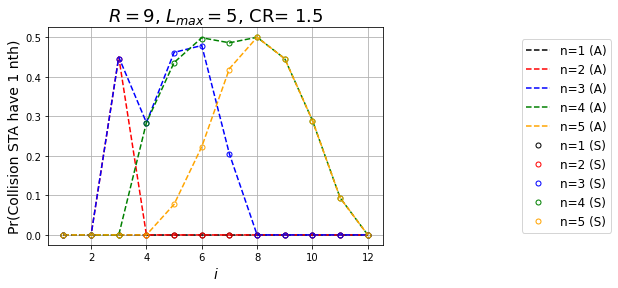

In [444]:
plt.plot(i_list, collision_STA_have_1_nth[0], linestyle = '--', color='black', label='n=1 (A)')
plt.plot(i_list, collision_STA_have_1_nth[1], linestyle = '--', color='red', label='n=2 (A)')
plt.plot(i_list, collision_STA_have_1_nth[2], linestyle = '--', color='blue', label='n=3 (A)')
plt.plot(i_list, collision_STA_have_1_nth[3], linestyle = '--', color='green', label='n=4 (A)')
plt.plot(i_list, collision_STA_have_1_nth[4], linestyle = '--', color='orange', label='n=5 (A)')

plt.plot(i_list, collision_STA_have_1_nth_simu[0], label='n=1 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(i_list, collision_STA_have_1_nth_simu[1], label='n=2 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(i_list, collision_STA_have_1_nth_simu[2], label='n=3 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(i_list, collision_STA_have_1_nth_simu[3], label='n=4 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(i_list, collision_STA_have_1_nth_simu[4], label='n=5 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(RA_RU) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$i$", fontsize = 14)
plt.ylabel("Pr(Collision STA have 1 nth)", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

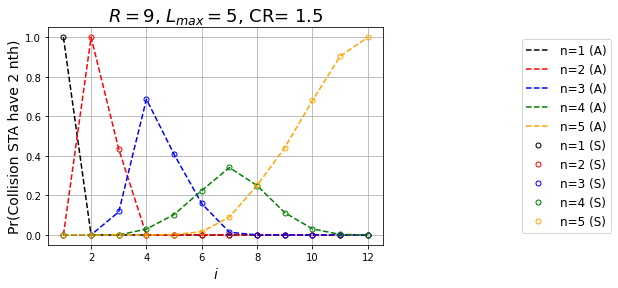

In [445]:
plt.plot(i_list, collision_STA_have_2_nth[0], linestyle = '--', color='black', label='n=1 (A)')
plt.plot(i_list, collision_STA_have_2_nth[1], linestyle = '--', color='red', label='n=2 (A)')
plt.plot(i_list, collision_STA_have_2_nth[2], linestyle = '--', color='blue', label='n=3 (A)')
plt.plot(i_list, collision_STA_have_2_nth[3], linestyle = '--', color='green', label='n=4 (A)')
plt.plot(i_list, collision_STA_have_2_nth[4], linestyle = '--', color='orange', label='n=5 (A)')

plt.plot(i_list, collision_STA_have_2_nth_simu[0], label='n=1 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(i_list, collision_STA_have_2_nth_simu[1], label='n=2 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(i_list, collision_STA_have_2_nth_simu[2], label='n=3 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(i_list, collision_STA_have_2_nth_simu[3], label='n=4 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(i_list, collision_STA_have_2_nth_simu[4], label='n=5 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(RA_RU) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$i$", fontsize = 14)
plt.ylabel("Pr(Collision STA have 2 nth)", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

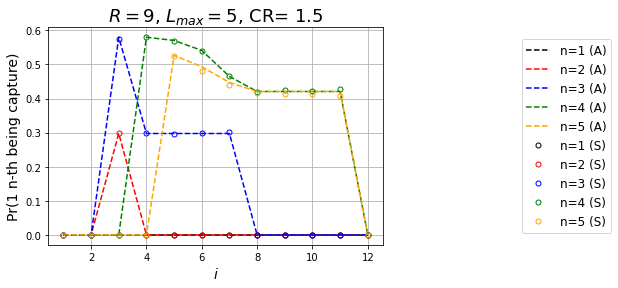

In [446]:
plt.plot(i_list, have_1_nth_capture[0], linestyle = '--', color='black', label='n=1 (A)')
plt.plot(i_list, have_1_nth_capture[1], linestyle = '--', color='red', label='n=2 (A)')
plt.plot(i_list, have_1_nth_capture[2], linestyle = '--', color='blue', label='n=3 (A)')
plt.plot(i_list, have_1_nth_capture[3], linestyle = '--', color='green', label='n=4 (A)')
plt.plot(i_list, have_1_nth_capture[4], linestyle = '--', color='orange', label='n=5 (A)')

plt.plot(i_list, have_1_nth_capture_simu[0], label='n=1 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(i_list, have_1_nth_capture_simu[1], label='n=2 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(i_list, have_1_nth_capture_simu[2], label='n=3 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(i_list, have_1_nth_capture_simu[3], label='n=4 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(i_list, have_1_nth_capture_simu[4], label='n=5 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(RA_RU) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$i$", fontsize = 14)
plt.ylabel("Pr(1 n-th being capture)", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

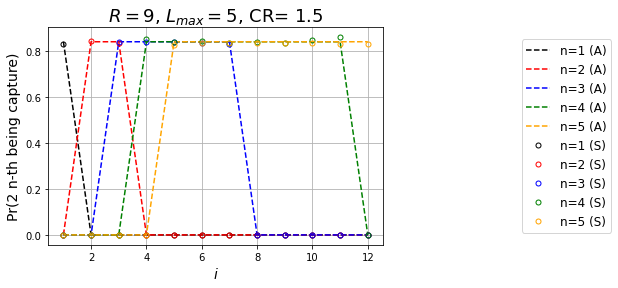

In [447]:
plt.plot(i_list, have_2_nth_capture[0], linestyle = '--', color='black', label='n=1 (A)')
plt.plot(i_list, have_2_nth_capture[1], linestyle = '--', color='red', label='n=2 (A)')
plt.plot(i_list, have_2_nth_capture[2], linestyle = '--', color='blue', label='n=3 (A)')
plt.plot(i_list, have_2_nth_capture[3], linestyle = '--', color='green', label='n=4 (A)')
plt.plot(i_list, have_2_nth_capture[4], linestyle = '--', color='orange', label='n=5 (A)')

plt.plot(i_list, have_2_nth_capture_simu[0], label='n=1 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(i_list, have_2_nth_capture_simu[1], label='n=2 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(i_list, have_2_nth_capture_simu[2], label='n=3 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(i_list, have_2_nth_capture_simu[3], label='n=4 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(i_list, have_2_nth_capture_simu[4], label='n=5 (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(RA_RU) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$i$", fontsize = 14)
plt.ylabel("Pr(2 n-th being capture)", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()